# Document Clustering and Topic Modeling for Movie Synopses

In this project, we use unsupervised learning models to cluster synopses of [Top 100 Greatest Movies of All Time from IMDB](http://www.imdb.com/list/ls055592025/) into different groups, visualize the results and identify their latent topics/structures.

## Contents

<ul>
<li>[Part 1: Load Data](#Part-1:-Load-Data)
<li>[Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
<li>[Part 3: TF-IDF](#Part-3:-TF-IDF)
<li>[Part 4: K-means clustering](#Part-4:-K-means-clustering)
<li>[Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)
</ul>

# Part 1: Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
import re
import os
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda

We got 100 movie titles and their synoposes (combined from imdb and wikipedia).

In [2]:
#import three lists: titles and wikipedia synopses
titles = open('data/title_list.txt').read().split('\n')
titles = titles[:100] #ensures that only the first 100 are read in

#The wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE". 
#Each synoposis may consist of multiple paragraphs.
synopses_wiki = open('data/synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('data/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

#Combine imdb and wiki to get full synoposes for the top 100 movies. 
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
#Because these synopses have already been ordered in popularity order, 
#we just need to generate a list of ordered numbers for future usage.
ranks = range(1, 1+len(titles))

# Part 2: Tokenizing and Stemming

Let's load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root (plain form).

In [3]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print "We use " + str(len(stopwords)) + " stop-words from nltk library."
print "Examples:", stopwords[:10]

We use 153 stop-words from nltk library.
Examples: [u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your']


In [4]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text, stemming=True):
    tokens=[]
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if word not in stopwords:
                tokens.append(word.lower())
                
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)            
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    if stemming:
        stems = [stemmer.stem(t) for t in filtered_tokens]
        return stems
    else:
        return filtered_tokens

In [5]:
# test
tokenization_and_stemming("Amy looked at her father's arm.")

[u'ami', u'look', u'father', "'s", u'arm']

Use our defined functions to analyze (i.e. tokenize, stem) our synoposes.

In [6]:
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    tokenized_results = tokenization_and_stemming(i, stemming=False)
    docs_tokenized.extend(tokenized_results)

Let's create a mapping from stemmed words to original tokenized words for result interpretation.

In [7]:
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
# test
print vocab_frame_dict['angel']

angeles


# Part 3: TF-IDF

In [8]:
# define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, min_df=0.2, stop_words='english',
                              use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

# fit the vectorizer to synopses
tfidf_matrix = tfidf_model.fit_transform(synopses) 

print "In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms."

In total, there are 100 synoposes and 538 terms.


In [9]:
# save the terms identified by TF-IDF
tf_selected_words = tfidf_model.get_feature_names()

# Part 4: K-means clustering

In [10]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state=0)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

## 4.1. Analyze K-means Result

In [11]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'cluster': clusters}
frame = pd.DataFrame(films, columns = ['rank', 'title', 'cluster'])
frame.head(10)

,rank,title,cluster
0,1,The Godfather,3
1,2,The Shawshank Redemption,1
2,3,Schindler's List,3
3,4,Raging Bull,0
4,5,Casablanca,1
5,6,One Flew Over the Cuckoo's Nest,1
6,7,Gone with the Wind,3
7,8,Citizen Kane,1
8,9,The Wizard of Oz,1
9,10,Titanic,2


In [12]:
print "Number of movies included in each cluster:"
frame['cluster'].value_counts().to_frame()

Number of movies included in each cluster:


,cluster
1,42
3,33
0,14
2,6
4,5


In [13]:
grouped = frame[['rank','cluster']].groupby('cluster')
print "Average rank (1 to 100) per cluster:"
grouped.mean()

Average rank (1 to 100) per cluster:


,rank
cluster,
0,58.214286
1,51.476190
2,45.666667
3,45.333333
4,60.600000


In [14]:
print "<Document clustering result by K-means>"

# km.cluster_centers_ denotes the importances of each items in centroid.
# need to sort it in descending order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print "Cluster " + str(i) + " words:" ,
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: # get the top 6 words of each cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print vocab_frame_dict[tf_selected_words[ind]] + ", ",
    print 

    cluster_movies = frame.loc[frame.cluster == i, 'title'].values.tolist()
    print "Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): " 
    print ", ".join(cluster_movies), '\n'

<Document clustering result by K-means>
Cluster 0 words: mr.,  father,  say,  brother,  robert,  killing, 
Cluster 0 titles (14 movies): 
Raging Bull, On the Waterfront, 12 Angry Men, Unforgiven, To Kill a Mockingbird, Braveheart, City Lights, Mr. Smith Goes to Washington, Annie Hall, Shane, The Green Mile, Nashville, The African Queen, Wuthering Heights 

Cluster 1 words: car,  police,  love,  apartment,  house,  father, 
Cluster 1 titles (42 movies): 
The Shawshank Redemption, Casablanca, One Flew Over the Cuckoo's Nest, Citizen Kane, The Wizard of Oz, Psycho, Sunset Blvd., Vertigo, Forrest Gump, West Side Story, E.T. the Extra-Terrestrial, The Silence of the Lambs, Chinatown, Singin' in the Rain, Some Like It Hot, Amadeus, Gandhi, Rocky, An American in Paris, My Fair Lady, The Good, the Bad and the Ugly, Butch Cassidy and the Sundance Kid, The Apartment, The Exorcist, The French Connection, It Happened One Night, Midnight Cowboy, Rain Man, Good Will Hunting, Tootsie, Fargo, The Grad

## 4.2. Plot K-means Result

In [15]:
# use PCA to select 2 principal components for visualization
pca = PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
X = pca.fit_transform(tfidf_matrix_np)
xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dictionary
cluster_colors = {0: 'k', 1: 'b', 2: 'r', 3: 'g', 4: 'm'}
#set up cluster names using a dictionary
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

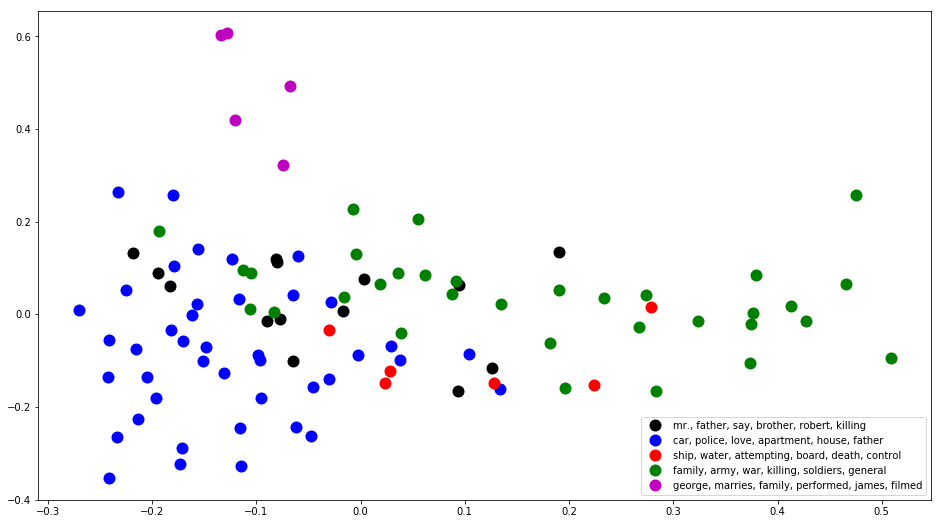

In [16]:
%matplotlib inline 

#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
#groups = df.groupby(clusters)
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    
#show legend with only 1 point
ax.legend(numpoints=1,loc='lower right')
plt.show() 

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [17]:
#Now we use synopses to build a 100*538 matrix
terms_dict = {tf_selected_words[x]:x for x in range(len(tf_selected_words))}

feature_matrix_synopses_tf = []
for i in synopses:
    current_doc_stats = [0] * len(tf_selected_words)
    allwords_stemmed = tokenization_and_stemming(i)
    for get_terms in allwords_stemmed:
        if get_terms in tf_selected_words:
            current_doc_stats[terms_dict[get_terms]] += 1
    current_doc_stats = np.asarray(current_doc_stats)
    feature_matrix_synopses_tf.append(current_doc_stats)
    
feature_matrix_synopses_tf = np.asarray(feature_matrix_synopses_tf)

In [18]:
model = lda.LDA(n_topics=5, n_iter=500, random_state=0)

<li> "model.topic\_word\_" saves the importance of tf_selected_words in LDA model, i.e. words similarity matrix
<li> The shape of "model.topic\_word\_" is (n_topics,num_of_selected_words)
<li> "model.doc\_topic\_" saves the document topic results, i.e. document topic matrix.
<li> The shape of "model.doc\_topic\_" is (num_of_documents, n_topics)

In [19]:
model.fit(feature_matrix_synopses_tf)
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 6

topic_keywords_list = []
for topic_dist in topic_word:    
    # Here we select the top 6 (n_top_words) words 
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-(n_top_words+1):-1] 
    for i in range(len(lda_topic_words)):
        lda_topic_words[i] = vocab_frame_dict[lda_topic_words[i]]
    topic_keywords_list.append(lda_topic_words.tolist())

INFO:lda:n_documents: 100
INFO:lda:vocab_size: 538
INFO:lda:n_words: 61218
INFO:lda:n_topics: 5
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -484683
INFO:lda:<10> log likelihood: -426218
INFO:lda:<20> log likelihood: -413064
INFO:lda:<30> log likelihood: -407511
INFO:lda:<40> log likelihood: -404390
INFO:lda:<50> log likelihood: -402397
INFO:lda:<60> log likelihood: -401017
INFO:lda:<70> log likelihood: -400082
INFO:lda:<80> log likelihood: -399172
INFO:lda:<90> log likelihood: -398632
INFO:lda:<100> log likelihood: -398018
INFO:lda:<110> log likelihood: -397244
INFO:lda:<120> log likelihood: -397115
INFO:lda:<130> log likelihood: -395914
INFO:lda:<140> log likelihood: -395814
INFO:lda:<150> log likelihood: -395540
INFO:lda:<160> log likelihood: -395466
INFO:lda:<170> log likelihood: -394710
INFO:lda:<180> log likelihood: -394213
INFO:lda:<190> log likelihood: -394417
INFO:lda:<200> log likelihood: -394490
INFO:lda:<210> log likelihood: -394427
INFO:lda:<220> log likelihood: -3943

In [20]:
doc_topic = model.doc_topic_
topic_doc_dict = {}

print "<Document clustering result by LDA>"
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print "Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i])
    print "Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): " 
    print ', '.join(topic_doc_dict[i]), '\n'

<Document clustering result by LDA>
Cluster 0 words: car, police, killing, meet, away, murder
Cluster 0 titles (15 movies): 
Casablanca, Titanic, Psycho, Sunset Blvd., The Silence of the Lambs, Chinatown, Doctor Zhivago, The French Connection, It Happened One Night, The Maltese Falcon, Taxi Driver, Double Indemnity, Rebel Without a Cause, The Third Man, North by Northwest 

Cluster 1 words: friend, say, n't, asks, run, fight
Cluster 1 titles (44 movies): 
The Shawshank Redemption, Raging Bull, One Flew Over the Cuckoo's Nest, Gone with the Wind, Citizen Kane, The Wizard of Oz, Vertigo, On the Waterfront, West Side Story, E.T. the Extra-Terrestrial, 2001: A Space Odyssey, Some Like It Hot, 12 Angry Men, From Here to Eternity, Unforgiven, Rocky, A Streetcar Named Desire, The Philadelphia Story, To Kill a Mockingbird, My Fair Lady, Ben-Hur, Jaws, The Apartment, Goodfellas, The Exorcist, The Deer Hunter, City Lights, The King's Speech, Mr. Smith Goes to Washington, Out of Africa, Tootsie, 